# Calculate density of intersections for a city

The process for calculating density of intersections for any city is:

- Grab the network data from OSM
- Convert the network to GeoDataframe
- Create a fishnet of ideally 500 sq. m. or 1 sq. km.
- Use spatial join to combine the two geo dataframes and then group the data by fishnet IDs.
 
With the spatial join, we're counting the number of intersection that intersect with the grid cell we created. That count gives the density of the intersections for the cell that can be visualized to create the density maps.

The functions plot the density graph along with intersections overlaid on fishnet.

In [1]:
## Importing packages

import osmnx as ox
from IPython.display import Image
from make_fishnet import make_fishnet
import shapely.speedups
import geocoder
import geopandas as gpd
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Getting the network data from OSM and creating a GDF from it

In [2]:
%%time
G = ox.graph_from_place('Piedmont, California', network_type='drive')
gdf = ox.graph_to_gdfs(G, nodes=True, edges=False)

CPU times: user 1.72 s, sys: 12 ms, total: 1.73 s
Wall time: 11.5 s


### Plot the nodes

Text(0.5, 1.0, 'Intersections in Piedmont, CA')

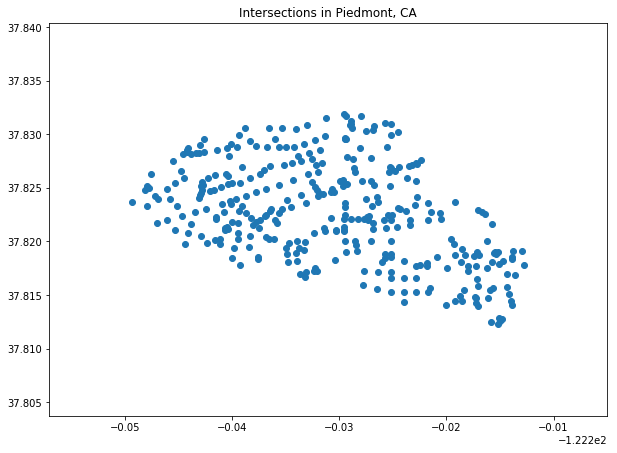

In [3]:
gdf.plot(figsize=[10,8])
pl.title('Intersections in Piedmont, CA')

### Geocode the place of interest to get the bounds for fishnet function

In [4]:
geo = geocoder.osm('Piedmont, California').geojson


xmin = geo['features'][0]['properties']['bbox'][0]
ymin = geo['features'][0]['properties']['bbox'][1]
xmax = geo['features'][0]['properties']['bbox'][2]
ymax = geo['features'][0]['properties']['bbox'][3]

string = 'Piedmont'

### Creating fishnet and reprojecting it to match that of geodataframe

In [5]:
make_fishnet('grid_data/Road_grid_{}.shp'.format(string), xmin,  xmax, ymin, ymax, 500, 500)
grid = gpd.GeoDataFrame.from_file('grid_data/Road_grid_{}.shp'.format(string))
grid.crs = {'init':'epsg:4326'}
grid = grid.to_crs(gdf.crs)

In [6]:
grid.head()

,FID,geometry
0,0,"POLYGON ((-122.249374 37.833026, -122.24488242..."
1,1,"POLYGON ((-122.249374 37.82734063060715, -122...."
2,2,"POLYGON ((-122.249374 37.82165526121431, -122...."
3,3,"POLYGON ((-122.249374 37.81596989182147, -122...."
4,4,"POLYGON ((-122.2448824235794 37.833026, -122.2..."


In [7]:
## Removing unwanted geometries from data

gdf = gdf.reset_index()

gdf = gdf.rename(columns ={'index':'id'})
gdf['geomType'] = gdf.geom_type
gdf = gdf[gdf['geomType'] != 'GeometryCollection']

In [9]:
## Merging the two shapefiles 

merged = gpd.sjoin( grid, gdf, how='left', op='intersects')

## Grouping the data by the FID of grid network
grp = merged.groupby('FID').count()

grid['node_count'] = grp.id

## Export the shapefile with roads fishnet
grid.to_file('{}_roads_fishnet.shp'.format(string))

/nfshome/gb1877/.conda/envs/osmpython/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


### Plot the outputs

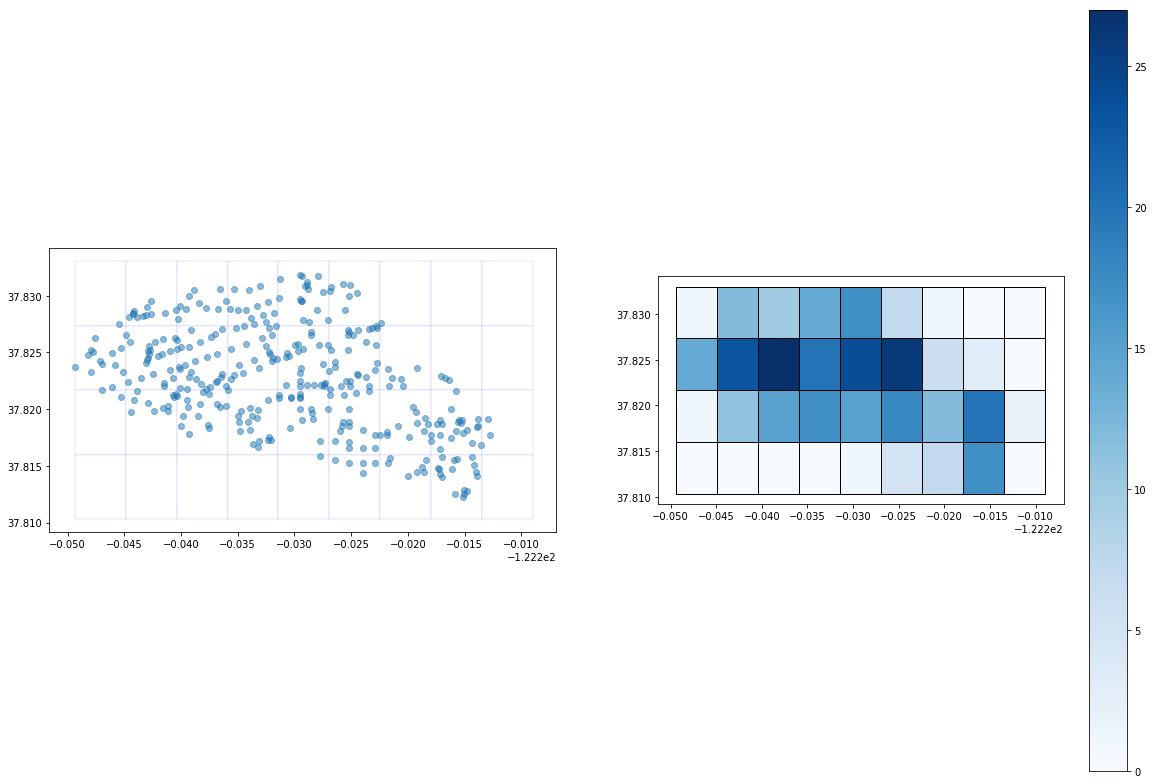

In [10]:
fig = pl.figure(figsize=(20,14))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
grid.plot(ax=ax1, facecolor='w',edgecolor='b',lw=0.1)
gdf.plot(ax=ax1, alpha=0.5);
grid.plot(ax=ax2, column='node_count', cmap='Blues', edgecolor='k', legend=True)

## Putting it all together

In [1]:
def get_node_count(place_name, pixel_size=None, geocode = 'arcgis'):
    """
    The function creates density maps of intersections in the city by creating a fishnet grid defined by the pixel_size.
    
    Parameters
    ----------
    
    place_name : str: The name of the area of interest
    pixel_size : int: The size of each pixel used for the fishnet. By default 500 is selected to crate a grid of 500 sq.m.
    geocode:     str: OSM and ArcGIS geocoder have their limitations. To provide an option, input 'osm' or 'arcgis' to geocode the data.
                      By default ArcGIS geocoder is used. 
                      
    Returns
    ----------
    
    A series of maps under the folder RoadDensity. Also returns shapefiles for fishnet grid and fishnet grid intersected with road network.
    
    """
    ## Setting initial crs
    crs = {'init':'epsg:4326'}
    
    string = place_name.split(',')[0]
    
    print('Fetching network data from OSM')
    
    ## Grabbing data from OSM
    G = ox.graph_from_place(place_name, network_type='drive')
    
    gdf_proj = ox.graph_to_gdfs(G, nodes=True, edges=False)
    
    ## Geocoding the city for fishnet grid
    if geocode == 'arcgis':
        geo = geocoder.arcgis(place_name)
        xmin = geo.geojson['features'][0]['properties']['raw']['extent']['xmin']
        ymin = geo.geojson['features'][0]['properties']['raw']['extent']['ymin']
        xmax = geo.geojson['features'][0]['properties']['raw']['extent']['xmax']
        ymax = geo.geojson['features'][0]['properties']['raw']['extent']['ymax']
    else:
        geo = geocoder.osm(place_name).geojson
        xmin = geo['features'][0]['properties']['bbox'][0]
        ymin = geo['features'][0]['properties']['bbox'][1]
        xmax = geo['features'][0]['properties']['bbox'][2]
        ymax = geo['features'][0]['properties']['bbox'][3]
    
    if pixel_size is not None:
        size = pixel_size
    else:
        size = 500
    
    print('Creating fishnet')
    
    ## Creating fishnet and exporting the file
    
    make_fishnet('grid_data/Road_grid_{}.shp'.format(string), xmin,  xmax, ymin, ymax, size, size)
    grid = gpd.GeoDataFrame.from_file('grid_data/Road_grid_{}.shp'.format(string))
    grid.crs = {'init':'epsg:4326'}
    grid = grid.to_crs(gdf_proj.crs)
    
    
    gdf_proj = gdf_proj.reset_index()
    
    ## Cleaning up the data by rmeoving invalid geometries
    
    gdf_proj = gdf_proj.rename(columns ={'index':'id'})
    gdf_proj['geomType'] = gdf_proj.geom_type
    gdf_proj = gdf_proj[gdf_proj['geomType'] != 'GeometryCollection']
    
    print('Merging datasets and calculating the count of nodes in each pixel')
    
    merged = gpd.sjoin( grid, gdf_proj, how='left', op='intersects')
    grp = merged.groupby('FID').count()
    
    grid['node_count'] = grp.id
    
    grid.to_file('{}_roads_fishnet.shp'.format(string)) ## Exporting fishnet file. This file has the data to plot
    
    
    print('Plotting outputs')
    fig = pl.figure(figsize=(20,14))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    grid.plot(ax=ax1, facecolor='w',edgecolor='b',lw=0.1)
    gdf_proj.plot(ax=ax1, alpha=0.5);
    grid.plot(ax=ax2, column='node_count', cmap='Blues', edgecolor='k', legend=True)
    
    ## Save footprints image
    print('Saving output 1')
    fig = pl.figure(figsize=(20,14))
    ax = fig.add_subplot(111)
    grid.plot(ax=ax, facecolor='w',edgecolor='b',lw=0.1)
    gdf_proj.plot(ax=ax, alpha=0.5);

    fig.savefig('RoadDensity/{}_overlay.png'.format(string))   # save the figure to file

    pl.close(fig)
    
    ## Save density image
    print('Saving output 2')
    fig = pl.figure(figsize=(20,14))
    ax2 = fig.add_subplot(111)
    grid.plot(ax=ax2, column='node_count', cmap='Blues', edgecolor='k', legend=True)

    fig.savefig('RoadDensity/{}_density.png'.format(string))   # save the figure to file

    pl.close(fig)
    
    ## Plot footprints and grid and Outputs
    print('Saving output 3')
    fig = pl.figure(figsize=(20,14))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    grid.plot(ax=ax1, facecolor='w',edgecolor='b',lw=0.1)
    gdf_proj.plot(ax=ax1, alpha=0.5);
    grid.plot(ax=ax2, column='node_count', cmap='Blues', edgecolor='k', legend=True)
    fig.savefig('RoadDensity/{}_comparison.png'.format(string))   # save the figure to file
    pl.close(fig)

### Piedmont, California

Fetching network data from OSM
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
Plotting outputs


/nfshome/gb1877/.conda/envs/osmpython/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Saving output 1
Saving output 2
Saving output 3
CPU times: user 3.02 s, sys: 24 ms, total: 3.05 s
Wall time: 6.84 s


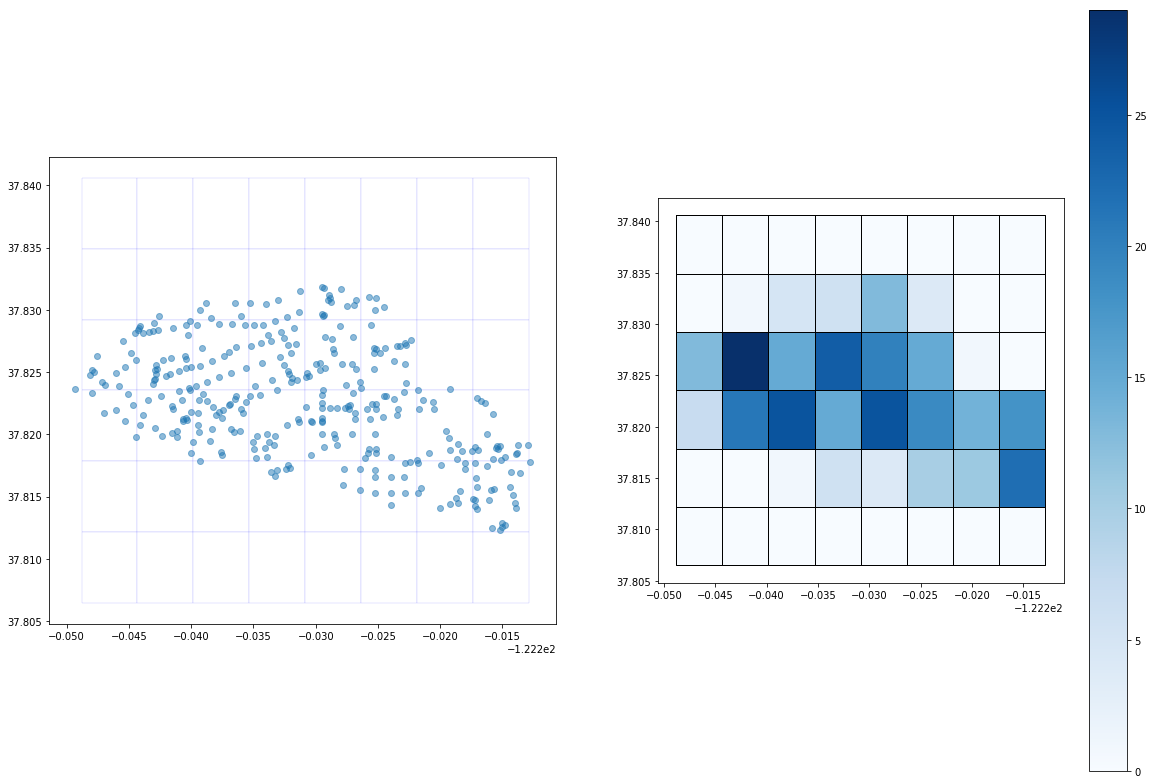

In [10]:
%%time

get_node_count('Piedmont, California')

### Darkhan, Mongolia

Fetching network data from OSM
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
Plotting outputs
Saving output 1
Saving output 2
Saving output 3
CPU times: user 4.6 s, sys: 24 ms, total: 4.62 s
Wall time: 6.87 s


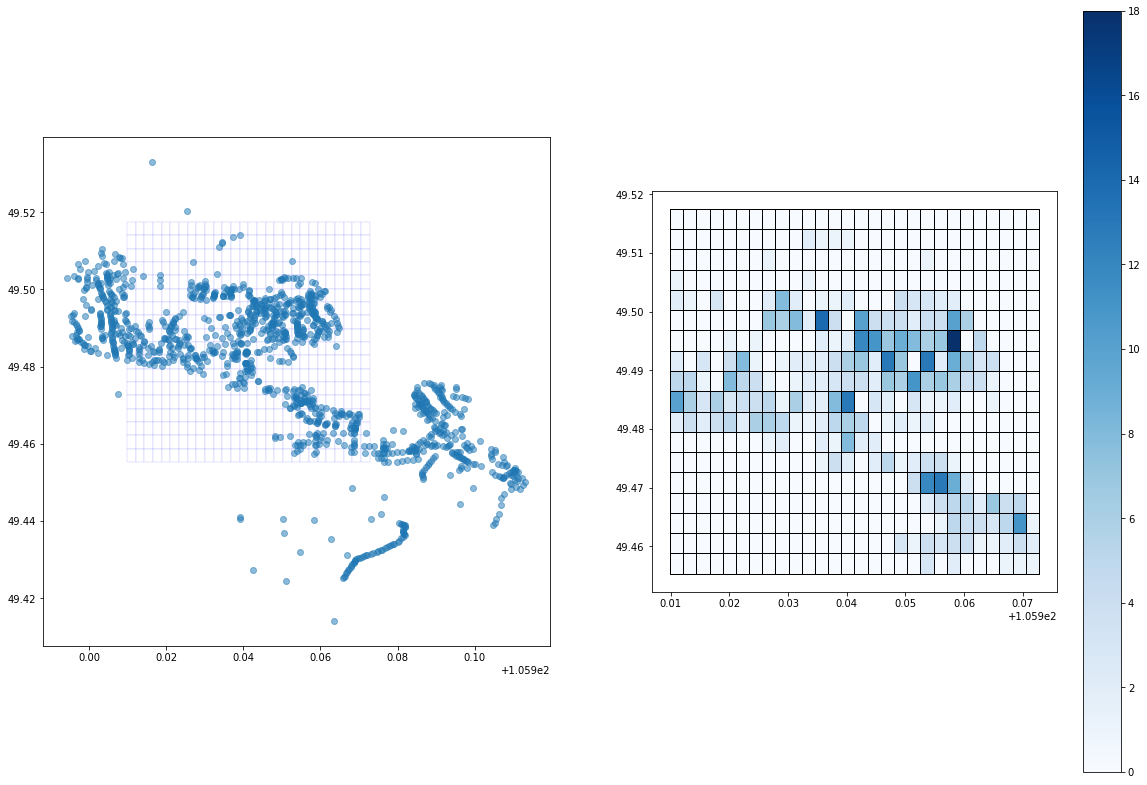

In [14]:
%%time

get_node_count('Darkhan, Mongolia', 250)

#### The extra data is because of improper geocoding. OSM geocoder doesn't work well for some places.

### Erdenet, Mongolia

Fetching network data from OSM
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
Plotting outputs
Saving output 1
Saving output 2
Saving output 3


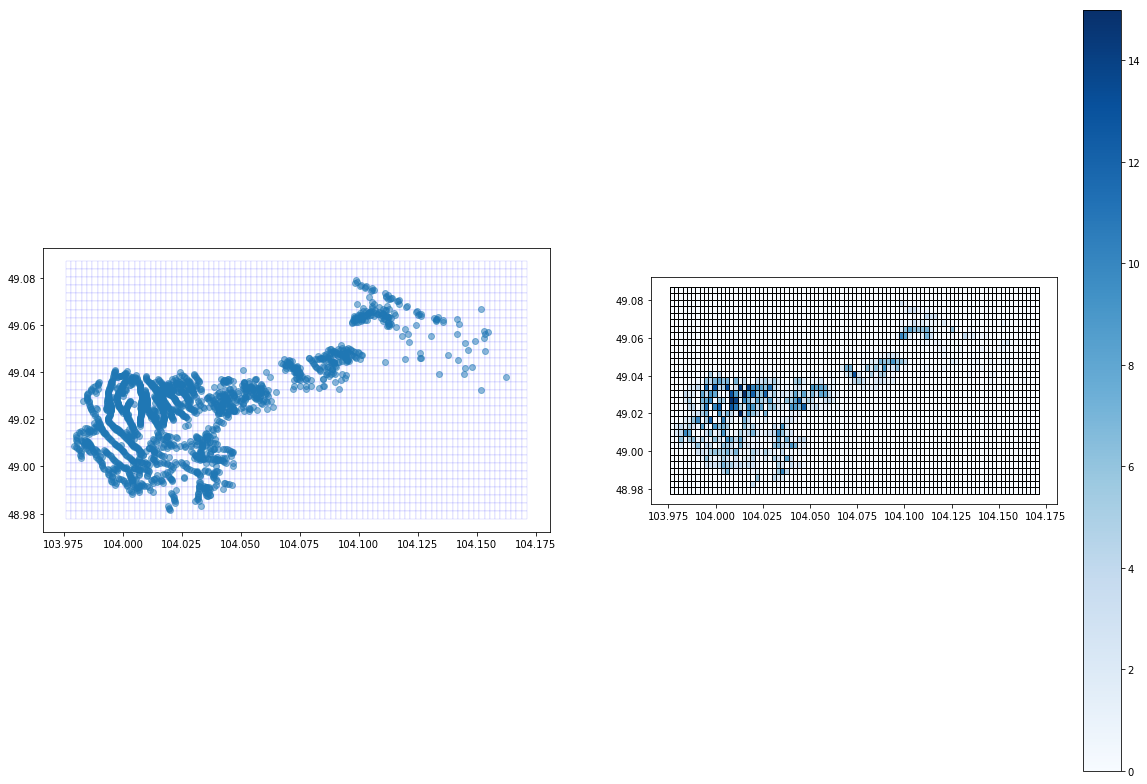

In [15]:
get_node_count('Erdenet, Mongolia', 250, geocode='osm')

### Ulannbaatar, Mongolia

Fetching network data from OSM
Creating fishnet
Merging datasets and calculating the count of nodes in each pixel
Plotting outputs
Saving output 1
Saving output 2
Saving output 3


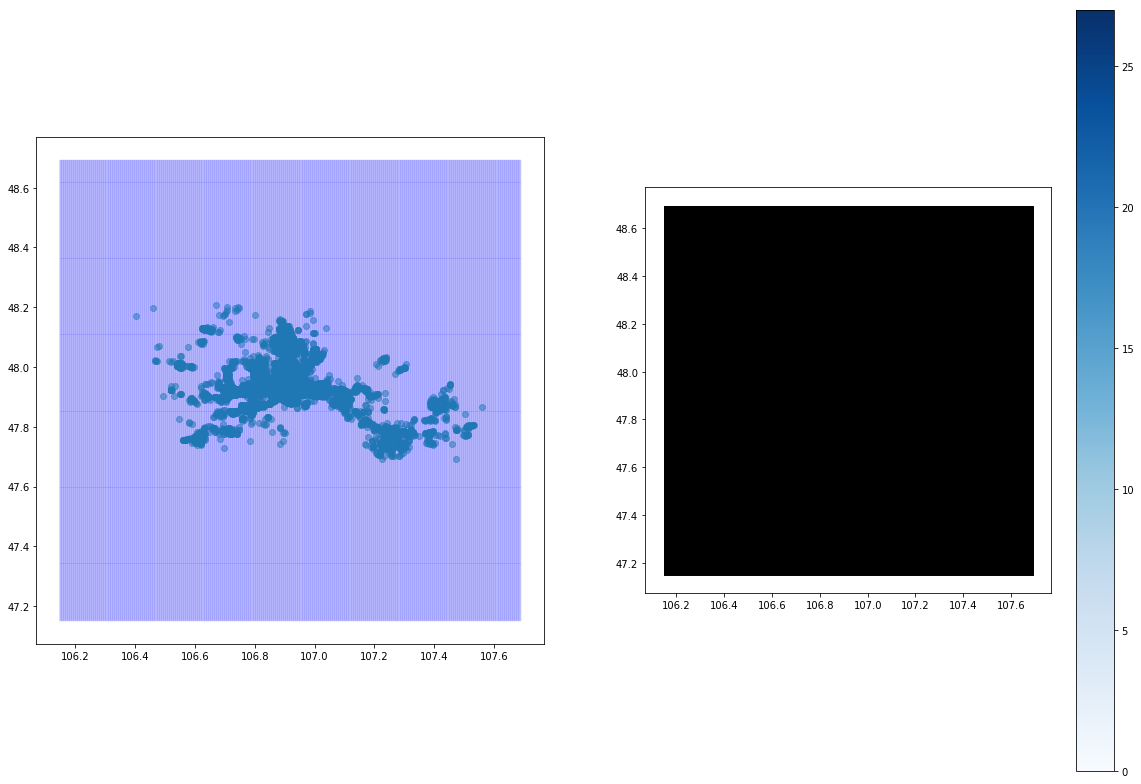

In [16]:
get_node_count('Ulaanbaatar, Mongolia', 250)